# Preprocessing

In [2]:
# import libraries
import matplotlib.pyplot as plt
import cv2
from glob import glob
import numpy as np
import math
%matplotlib inline

# Loading dataset

In [3]:
dataset_path='/path/to/dataset/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

train_dir=dataset_path+"training/"
test_dir=dataset_path+"test/"

train_image_dir=train_dir+"images/"
train_mask_dir=train_dir+"mask/"
train_groundtruth_dir=train_dir+"1st_manual/"
train_patch_dir=train_dir+"patch/"

test_image_dir=test_dir+"images/"
test_mask_dir=test_dir+"mask/"
test_save_dir=test_dir+"pred_result/"

train_image_path_list=glob(train_image_dir+"*.tif")
test_image_path_list=glob(test_image_dir+"*.tif")

# replaces doubles slashes with one
train_image_path_list=[i.replace("\\","/") for i in train_image_path_list]
test_image_path_list=[i.replace("\\","/") for i in test_image_path_list]


# RGB channels of training set

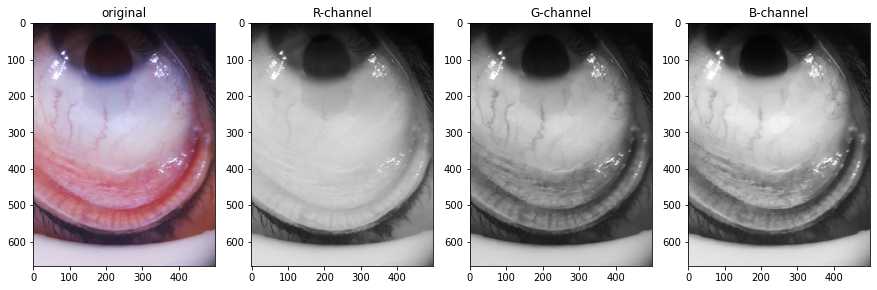

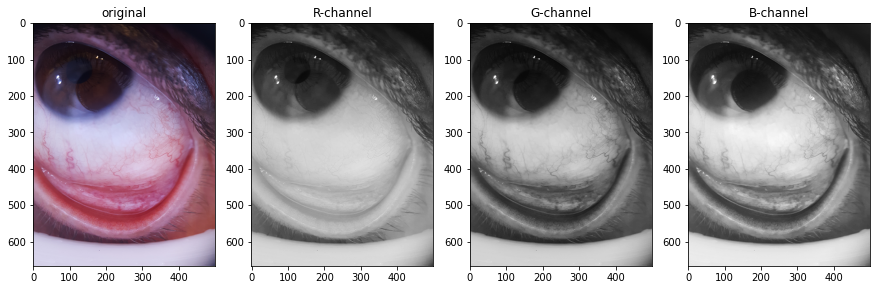

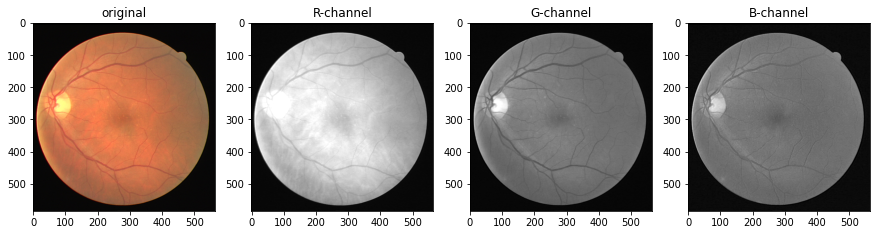

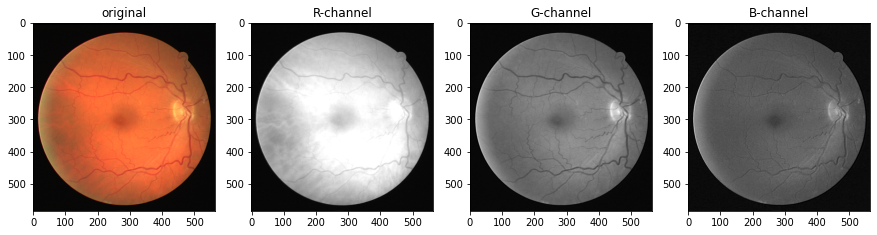

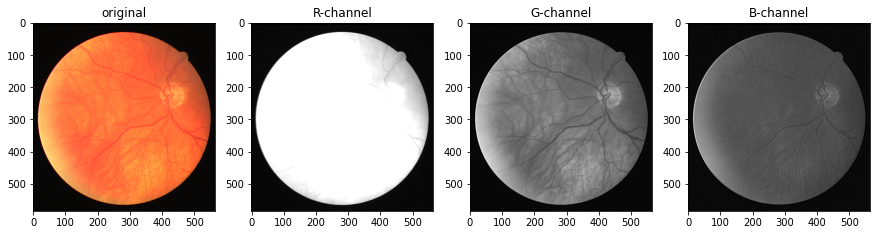

In [4]:
for image_path in train_image_path_list[:5]:
  image=plt.imread(image_path)

  plt.figure(figsize=(15,15))
  plt.subplot(141)
  plt.title("original")
  plt.imshow(image)
  plt.subplot(142)
  plt.title("R-channel")
  plt.imshow(image[:,:,0],cmap=plt.cm.gray)
  plt.subplot(143)
  plt.title("G-channel")
  plt.imshow(image[:,:,1],cmap=plt.cm.gray)
  plt.subplot(144)
  plt.title("B-channel")
  plt.imshow(image[:,:,2],cmap=plt.cm.gray)
  plt.show()

# Preprocessing's functions 

In [5]:
def normal_normalized_single(imgs,mask):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[2]):
        imgs_normalized[:,:,i] = ((imgs_normalized[:,:,i] - np.min(imgs_normalized[:,:,i])) / (np.max(imgs_normalized[:,:,i])-np.min(imgs_normalized[:,:,i])))*255
    return imgs_normalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_single(imgs):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  imgs_equalized = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_equalized[:,:,i] = clahe.apply(np.array(imgs[:,:,i], dtype = np.uint8))
  return imgs_equalized


def adjust_gamma_single(imgs, gamma=1.0):
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  # apply gamma correction using the lookup table
  new_imgs = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    new_imgs[:,:,i] = cv2.LUT(np.array(imgs[:,:,i], dtype = np.uint8), table)
  return new_imgs

def preprocess_single(image,mask):
  
  assert np.max(mask)==1
  image=np.array(image)
  image[:,:,0]=image[:,:,0]*mask
  image[:,:,1]=image[:,:,1]*mask
  image[:,:,2]=image[:,:,2]*mask
  
  image=normal_normalized_single(image,mask)
  image=clahe_equalized_single(image)
  image=adjust_gamma_single(image,1.2)
  image=image/255.0
  return image

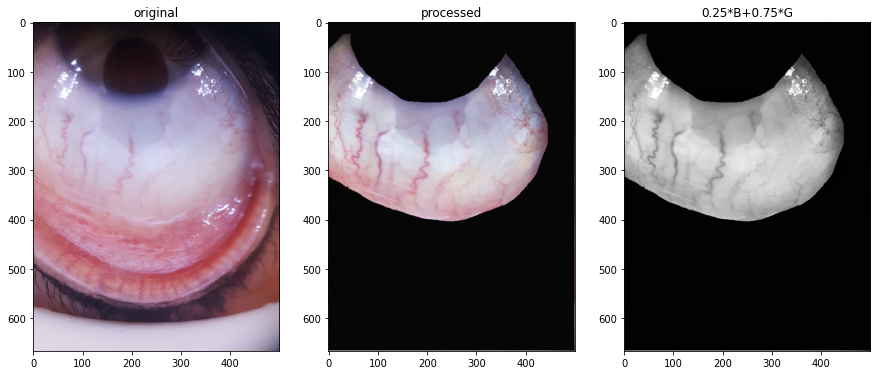

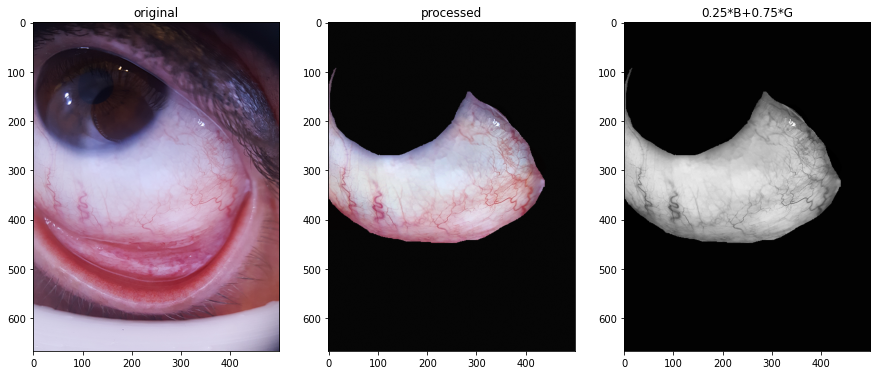

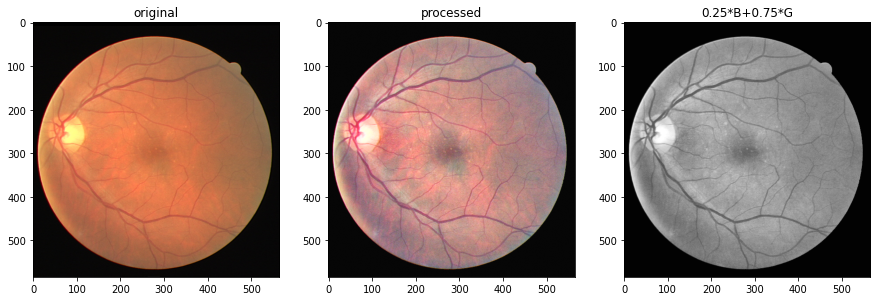

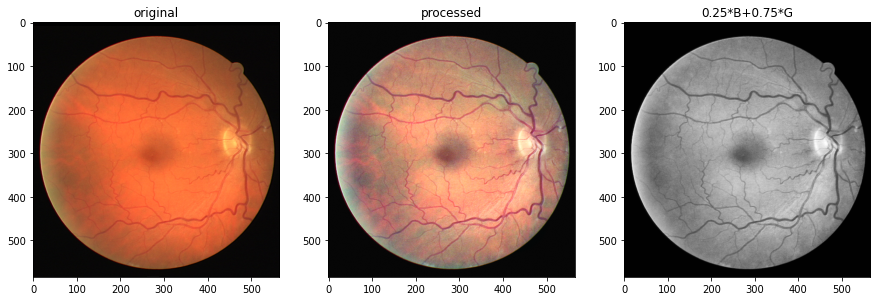

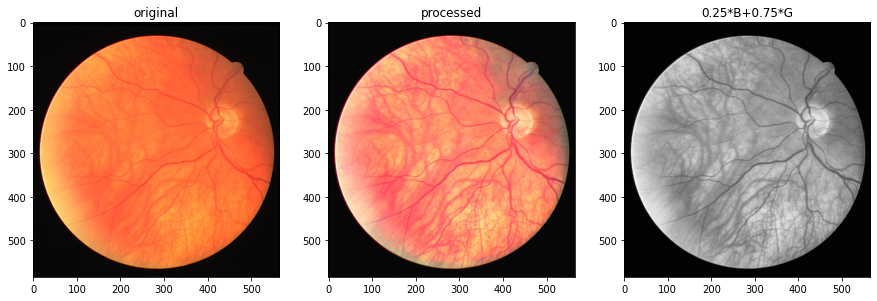

In [8]:
list_images=[]

i=0
for image_path in train_image_path_list:
  image_name=image_path.split("/")[-1].split("_")[0]

  image=plt.imread(image_path)

  mask=plt.imread(train_mask_dir+image_name+"_training_mask.gif")
  mask=np.where(mask>0,1,0)
  image_original=image.copy()
  image_processed=preprocess_single(image,mask)
  image_processed_binary=np.asarray(0.2*image_processed[:,:,0]+0.8*image_processed[:,:,1])
  
  if i < 5:
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("original")
    plt.imshow(image_original)
    plt.subplot(132)
    plt.title("processed")
    plt.imshow(image_processed)
    plt.subplot(133)
    plt.title("0.25*B+0.75*G")
    plt.imshow(image_processed_binary,cmap=plt.cm.gray)
    plt.show()

  image_processed_binary=np.expand_dims(image_processed_binary,0)
  list_images.append(image_processed_binary)
  i+=1